# Init

In [1]:
using LinearAlgebra
using NearestNeighbors
using StaticArrays
include("utils.jl"   )
include("kernels.jl" );

# Problem Domain

In [2]:
_DIM_X    = 2
_DIM_A    = 2
_X_DOMAIN = [-2.0 +2.0; -2.0 +2.0]
_A_DOMAIN = [-0.5 +0.5; -0.5 +0.5]
_Q_DOMAIN = [_X_DOMAIN; _A_DOMAIN]
_LEAFLEN  = 10

10

# Simple Test Environment

In [3]:
nX = _DIM_X; # ---- State    dims
nA = _DIM_A; # ---- Action   dims
nQ = nX + nA; # --- Combined dims
X  = zeros( nX ); # Current position
A  = zeros( nA ); # Current effort
Q  = zeros( nQ ); # Current Q state


"""
Assemble <State,Action> into Q-state
"""
function get_Q( X, A )
    res = zeros( nQ );
    res[ 1:nX ]    = X;
    res[ nX+1:nQ ] = A;
    return res;
end


"""
Disassemble <State,Action> into Q-state
"""
function XA_from_Q( Q )
    return Q[ 1:nX ], Q[ nX+1:nQ ];
end

    

"""
Extremely simple dynamics, effort is the position offset applied
"""
function dyn( X, A )
    A = clamp_vec( A, _A_DOMAIN );
    X = clamp_vec( X + A, _X_DOMAIN );
    return get_Q( X, A );
end

dyn

# Interpolated Q-Learning Procedure

## Agent Components

In [4]:
# Construct grid of anchors
anchors = regular_grid_pts_nD( _Q_DOMAIN, [1.0,1.0,0.25,0.25] );
nPts    = size( anchors )[2]; # - Number of anchors
mDim    = size( anchors )[1]; # - Dimensionality of anchors 
pnts    = copy( anchors ); # ---- Interpolation anchors
vals    = zeros(Float64, nPts); # Values at anchors
vsts    = zeros(Int64, nPts); # - Set number of visits to zero
vAcc    = zeros(Float64, nPts); # Accumulated value per point per iteration
println( size( anchors ) )

# Construct spatial trees over anchors (WITHOUT reordering!)
Q_kdTree = KDTree( pnts            ; leafsize = _LEAFLEN, reorder = false ); # Vals must remain assoc w pnts!
X_kdTree = KDTree( pnts[1:_DIM_X,:]; leafsize = _LEAFLEN, reorder = false ); # Vals must remain assoc w pnts!
Q_blTree = BallTree( pnts             ); 
X_blTree = BallTree( pnts[1:_DIM_X,:] ); 

(4, 625)


## Training

### `DEV PLAN`
```
[ ] Repeat training success of previous rev (extremely slow, but correct, learning)
[ ] Display how much values change each iteration and by the end of training
[ ] Double-check adaptive learning rates for correctness! 
[ ] Investigate stability of learning much faster
```

## Agent Params

In [5]:
##### Params #####
gamma = 0.950; # ---------- FIXME
beta  = 1 / (1.0-gamma); # FIXME
h     = 1.0; # ----------- scale
T     = 6400; #1600#3200; # ----------- training period
Y_0   = [0.0 0.0]; # ----- starting state

In [6]:
##### Helpers #####

R_func = get_planar_reward_function( _DIM_X, 2 ) # XY function with reward slope 2.0


"""
Random Exploration Policy
"""
function pi_E()
    return sample_bbox_uniform( _A_DOMAIN );
end


"""
Perform a linear hyperplane Least Squared Error fit with independent `X` and dependent `Y`
SOURCE: https://stanford.edu/class/engr108/lectures/julia_least_squares_slides.pdf
"""
function least_sqrs_fit( X, Y )
    N          = size( X, 2 )
    beta_tilde = [ ones(N,1) X' ] \ Y;
    fitEQ      = beta_tilde[2:end];
    err        = beta_tilde[1]; 
    return fitEQ, err 
end


"""
Return points that represent positive and negative offsets in the cardinal directions from `q`
"""
function compass_points( q, offset )
    nDim   = max( size( q )... ) 
    # println( "Center point has dimension ", nDim )
    Q      = zeros( nDim )
    Q[:]   = q
    rtnPts = zeros( nDim, 2*nDim )
    for j = 1:nDim
        offVec      = zeros( nDim )
        offVec[j]   = offset
        rtnPts[:,j*2-1] = Q - offVec
        rtnPts[:,j*2  ] = Q + offVec
    end
    return rtnPts
end


"""
Get the vector of steepest ascent on a fit hyperplane at `q` w.r.t. `Y` given column matrix of points `X`
"""
function steepest_Y_ascent( X, Y )
    # mDim     = size( X, 1 ) # -------------- Get problem size
    fitEQ, _ = least_sqrs_fit( X, Y ) # ---- Fit a hyperplane
    return fitEQ
end


"""
Given a spatial tree of states and associate values, find action that ascends the reward gradient at `X`
"""
function optimal_action_for_state( xBlTree, X, radius, pnts, vals, Adomain )
    # 1. Fetch `X` neighborhood anchors within `radius`
    idxs = inrange( xBlTree, X, radius )
    
    # p, v = fetch_by_indices( pnts[_DIM_X+1:end,:], vals, idxs )
    p, v = fetch_by_indices( pnts[1:_DIM_X,:], vals, idxs ) # The model has to be right!
    
    # N. Return optimal action according to local value gradient
    return clamp_vec( 
        steepest_Y_ascent( p, v ), 
        Adomain
    )
end


"""
Fetch all the anchor indices that have a visit count of at least 1
"""
function fetch_visted_indices( visitArr )
    rtnDxs = []
    nPts   = size( visitArr, 1 )
    for j = 1:nPts
        if visitArr[j] >= 1
            append!( rtnDxs, j )
        end
    end
    return rtnDxs
end

"""
Set all anchor visits to zero
"""
function empty_visited_arr( visitArr )
    return zeros(Int64, size( visitArr ) ); 
end


# function arrayify( juliaVec )
#     len = 0
#     if isa( juliaVec, Vector{Float64} )
#         len = length(juliaVec)
#         rtnArr = zeros( len, 1, )
#         for i in 1:len
#             rtnArr[i] = juliaVec[i]
#         end
#         return rtnArr
#     end
    
#     return juliaVec
# end


"""
Calc the unit vector in the same direction as arg
"""
function vec_unit( vec )
    len = norm( vec )
    if len == 0.0
        return vec
    else
        return vec / len
    end
end

vec_unit

## Agent Learning Loop

In [7]:
Rtot = 0.0
    
# 0. Set the initial state
X[:] = Y_0[:]

scale = 1.25

# 1. For the designated number of training steps, do
for t = 1:T
    
    
    # Cache last state
    xLast = copy( X )
    aLast = copy( A )
    qLast = get_Q( xLast, aLast )
    
    # 2. Draw action
    a_t  = pi_E()
    a_t  = vec_unit( a_t ) * norm( _A_DOMAIN[:,2] )
    A[:] = a_t
    
    # 3. Generate the next stae
    Q_nxt = dyn( X, A )
    
    # 4. Collect reward R( s, a, s' )
    xP, _ = XA_from_Q( Q_nxt )
    R_t   = R_func( xLast, A, xP )
    Rtot  += R_t
    
    # 5. Get the optimal action at the next state
    a_tp1_opt = optimal_action_for_state( X_blTree, xP, scale, pnts, vals, _A_DOMAIN )
    a_lrg_opt = vec_unit( a_tp1_opt ) * norm( _A_DOMAIN[:,2] )
    a_lim_opt = clamp_vec( a_lrg_opt, _A_DOMAIN )
    
    if t%100 == 0
        # println( a_tp1_opt, a_lrg_opt, a_lim_opt )
        println( xLast, "\t\t", a_t, "\t\t", R_t, "\t\t", a_lim_opt )
    end
    
    
    # 6. Compute the value at the next state
    # V_tp1_opt = query_value_w_knn( Q_kdTree, pnts, vals, get_Q( xP, a_tp1_opt ); k = 6 )
    V_tp1_opt = query_value_w_knn( Q_kdTree, pnts, vals, get_Q( xP, a_lim_opt ); k = 6 )
    
    
    # 7. Find the local neighborhood of anchors within `h` radius of the last state
    idxs  = inrange( X_blTree, xLast, scale )
    nBall = size( idxs, 1 )
    # println( "There are ", nBall, " points in this neighborhood" )
    # p, v  = fetch_by_indices( pnts, vals, idxs )
    
    # 8. For each anchor whose ball encloses the last state
    for i = 1:nBall 
        # 9. Fetch visits and calc learning rate
        j     = idxs[i]
        N_k   = vsts[j]
        eta_N = 1 / ( N_k + 1 )
                
        if N_k > 0
            vAcc[j] = (1 - eta_N) * vAcc[j] + eta_N * ( R_t + gamma * V_tp1_opt )
        else
            vAcc[j] = R_t + gamma * V_tp1_opt
        end
        
        vsts[j] += 1
        
        # println( "\tNeighbor ", i, ", Index ", j, ", with ", vsts[j], " visits.  Accumulate ", vAcc[j], " value." )
        
    end
    
    # 10. Fetch visited
    vDices = fetch_visted_indices( vsts )
    Nvst   = size( vDices, 1 )
    
    # println( "\t###" )
    
    # 11. For each visited, blend accumulated value change into present value
    for k = 1:Nvst
        alpha_k = beta / (beta+k)
        j       = vDices[k]
        vals[j] = (1-alpha_k)*vals[j] + alpha_k*vAcc[j]
        # println( "\tNew value at index ", j, " is ", vals[j] )
    end
    
    # 12. Set up the next iteration
    vsts = empty_visited_arr( vsts )
    X    = copy( xP )
    
end

[0.8654131169525657, 1.3053899411133734]		[0.675480304100456, -0.20910848565363263]		2.4616945724123065		[0.5, 0.5]
[-1.5, 1.4449805399839912]		[-0.3248788771056777, -0.6280555032881681]		-0.8798983371216864		[-0.5, 0.5]
[0.31702425310625837, -1.2015308724577765]		[-0.5135983129089929, -0.48602137090567954]		-1.8705279902571976		[-0.31114835803547175, 0.5]
[-0.07751485040650681, 1.473018866611169]		[-0.6204287349972218, 0.33921701724669884]		1.234721033451361		[0.5, -0.2813351092856476]
[2.0, -2.0]		[0.5535907528302775, -0.4399287196589997]		0.0		[-0.11178567040889716, 0.5]
[-0.2347701268415699, 1.548255875139754]		[0.664437744359874, 0.2419142076645414]		2.0553999559627254		[0.5, 0.5]
[-0.5482598559382894, 1.8462605134527021]		[-0.471676100133301, -0.5268032427415762]		0.32632455738111177		[0.5, -0.5]
[-1.108356686870351, 0.0]		[-0.4031839654073808, 0.5808981752754782]		-1.0115406522777317		[0.5, 0.5]
[-0.92656659959294, 1.1518146167245327]		[-0.3430352924413766, 0.6183257944964445]		

## Agent Params

In [5]:
##### Params #####
gamma = 0.950; # ---------- FIXME
beta  = 1 / (1.0-gamma); # FIXME
h     = 1.0; # ----------- scale
T     = 6400; #1600#3200; # ----------- training period
Y_0   = [0.0 0.0]; # ----- starting state

# Value Function Rep

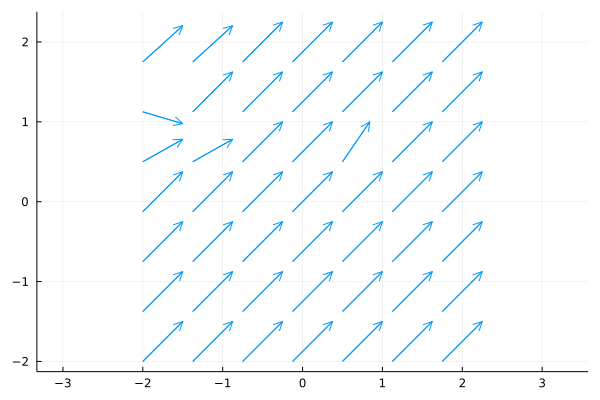

In [8]:
using Plots
using LinearAlgebra

xs = _X_DOMAIN[1,1] : scale/2.0 : _X_DOMAIN[1,2]
ys = _X_DOMAIN[2,1] : scale/2.0 : _X_DOMAIN[2,2]

df(x, y) = optimal_action_for_state( X_blTree, [x; y], scale, pnts, vals, _A_DOMAIN ) 

xxs = [x for x in xs for y in ys]
yys = [y for x in xs for y in ys]

quiver(xxs, yys, quiver=df, aspect_ratio=:equal)

# Optimal Agent Test

In [9]:
Rtot = 0.0

# 0. Set the initial state
X[:] = Y_0[:]

# scale = 1.0

# 1. For the designated number of training steps, do
for t = 1:T
    
    # Cache last state
    xLast = copy( X )
    aLast = copy( A )
    qLast = get_Q( xLast, aLast )
    
    # Choose an action
    A = optimal_action_for_state( X_blTree, X, scale, pnts, vals, _A_DOMAIN )
    A = vec_unit( A ) * norm( _A_DOMAIN[:,2] ) * 0.5
    A = clamp_vec( A, _A_DOMAIN )
    
    # 3. Generate the next stae
    Q_nxt = dyn( X, A )
    
    # 4. Collect reward R( s, a, s' )
    X, _  = XA_from_Q( Q_nxt )
    R_t   = R_func( xLast, A, X )
    Rtot  += R_t
    
    println( "X: ", X, ", A: ", A, ", R: ", R_t )
    
end

println( "Total   Reward: ", Rtot   )
println( "Average Reward: ", Rtot/T )

X: [0.25, 0.25], A: [0.25, 0.25], R: 0.5
X: [0.44971767343334584, 0.5417410682752284], A: [0.19971767343334584, 0.2917410682752284], R: 0.9914587417085743
X: [0.6494353468666917, 0.8334821365504568], A: [0.19971767343334584, 0.2917410682752284], R: 1.4829174834171486
X: [0.8994353468666917, 1.0834821365504568], A: [0.25, 0.25], R: 1.9829174834171486
X: [1.1494353468666918, 1.3334821365504568], A: [0.25, 0.25], R: 2.4829174834171486
X: [1.3994353468666918, 1.5834821365504568], A: [0.25, 0.25], R: 2.9829174834171486
X: [1.6494353468666918, 1.8334821365504568], A: [0.25, 0.25], R: 3.4829174834171486
X: [1.8994353468666918, 2.0], A: [0.25, 0.25], R: 3.899435346866692
X: [2.0, 2.0], A: [0.25, 0.25], R: 4.0
X: [2.0, 2.0], A: [0.25, 0.25], R: 4.0
X: [2.0, 2.0], A: [0.25, 0.25], R: 4.0
X: [2.0, 2.0], A: [0.25, 0.25], R: 4.0
X: [2.0, 2.0], A: [0.25, 0.25], R: 4.0
X: [2.0, 2.0], A: [0.25, 0.25], R: 4.0
X: [2.0, 2.0], A: [0.25, 0.25], R: 4.0
X: [2.0, 2.0], A: [0.25, 0.25], R: 4.0
X: [2.0, 2.0], A

# kD Kernel

In [10]:
_DIM_X    = 2
_DIM_A    = 2
_X_DOMAIN = [-2.0 +2.0; -2.0 +2.0]
_A_DOMAIN = [-0.5 +0.5; -0.5 +0.5]
_Q_DOMAIN = [_X_DOMAIN; _A_DOMAIN]
_LEAFLEN  = 10

anchors = regular_grid_pts_nD( _X_DOMAIN, [0.25,0.25] );

nPts = size( anchors )[2]; # - Number of anchors
mDim = size( anchors )[1]; # - Dimensionality of anchors 
pnts = copy( anchors ); # ---- Interpolation anchors
vals = zeros(Float64, nPts); # Values at anchors
        
println( size( anchors ) )

(2, 289)


In [11]:
Q_kdTree = KDTree( pnts            ; leafsize = _LEAFLEN, reorder = false ); # Vals must remain assoc w pnts!

# println( pnts[1:_DIM_X,11] ) # Check X slice order
# println( pnts[1:_DIM_X,23] )
# println( pnts[1:_DIM_X,35] )

# X_kdTree = KDTree( pnts[1:_DIM_X,:]; leafsize = _LEAFLEN, reorder = false ); # Prohibit slice reorder

# println( pnts[1:_DIM_X,11] ) # Check X slice consistent 
# println( pnts[1:_DIM_X,23] )
# println( pnts[1:_DIM_X,35] )

In [12]:
truthFunc = get_nD_example_plane_eq( _DIM_X, 1 )
assoc_pnts_with_true_values( pnts, vals, truthFunc )
display( query_value_w_knn( Q_kdTree, pnts, vals, [2; 2;]; k = 6 ) )

1.8333333333333333

In [13]:
bbox = _X_DOMAIN
N    = 50
smpl = sample_bbox_N( bbox, N )
err  = 0.0

for j = 1:N
    smp = smpl[:,j]
    est = query_value_w_knn( Q_kdTree, pnts, vals, smp; k = 6 )
    tru = truthFunc( smp )
    err += abs( est - tru )
end

println( "Average error for knn kernel on plane: ", err/N )

Average error for knn kernel on plane: 0.025792159197633047


## Radius Kernel

In [14]:
Q_blTree = BallTree( pnts             ); # Vals must remain assoc w pnts!
# X_blTree = BallTree( pnts[1:_DIM_X,:] ); # Prohibit slice reorder

In [15]:
bbox = _X_DOMAIN
N    = 50
smpl = sample_bbox_N( bbox, N )
err  = 0.0

for j = 1:N
    smp = smpl[:,j]
    est = query_store_w_radius( Q_blTree, pnts, vals, smp; radius = 1.0 )
    tru = truthFunc( smp )
    err += abs( est - tru )
end

println( "Average error for knn kernel on plane: ", err/N )

Average error for knn kernel on plane: 0.04981996068105042


## Gaussian Kernel

In [16]:
err  = 0.0

for j = 1:N
    smp = smpl[:,j]
    est = query_value_w_gauss( pnts, vals, smp )
    tru = truthFunc( smp )
    err += abs( est - tru )
end

println( "Average error for radius kernel on hill: ", err/N )

Average error for radius kernel on hill: 0.043534700615049896
